In [1]:
# Cell 1: Setup & Load Library
import sys
import os
import pandas as pd

# Thêm đường dẫn src để import được thư viện tự viết
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from cluster_library import RuleBasedCustomerClusterer

# Cấu hình hiển thị
%matplotlib inline
print("✅ Setup hoàn tất! Đã sẵn sàng chạy phân cụm.")

✅ Setup hoàn tất! Đã sẵn sàng chạy phân cụm.


In [2]:
# Cell 2: Khởi tạo Clusterer và Load Rules
# Đường dẫn file (tương đối so với thư mục notebooks)
RULES_PATH = os.path.join('..', 'data', 'processed', 'rules.csv')
TRANS_PATH = os.path.join('..', 'data', 'raw', 'online_retail_II.xlsx')

# Khởi tạo
clusterer = RuleBasedCustomerClusterer()

# Load 50 luật mạnh nhất theo Lift
# Bạn có thể thử đổi top_k=30 hoặc top_k=100 để xem kết quả thay đổi thế nào
clusterer.load_and_filter_rules(RULES_PATH, top_k=50, metric='lift')

# Xem thử vài luật đầu tiên
print("\nTop 5 luật mạnh nhất được sử dụng:")
print(clusterer.rules[['antecedents_parsed', 'consequents', 'lift']].head())

🔄 Đang tải luật từ ..\data\processed\rules.csv...
✅ Đã chọn 50 luật tốt nhất dựa trên lift.

Top 5 luật mạnh nhất được sử dụng:
                     antecedents_parsed  \
0                   {TOILET METAL SIGN}   
1                 {BATHROOM METAL SIGN}   
2   {RED 3 PIECE MINI DOTS CUTLERY SET}   
3  {BLUE 3 PIECE MINI DOTS CUTLERY SET}   
4               {HEART OF WICKER SMALL}   

                                         consequents       lift  
0                 frozenset({'BATHROOM METAL SIGN'})  22.480592  
1                   frozenset({'TOILET METAL SIGN'})  22.480592  
2  frozenset({'BLUE 3 PIECE MINI DOTS CUTLERY SET'})  20.840341  
3   frozenset({'RED 3 PIECE MINI DOTS CUTLERY SET'})  20.840341  
4               frozenset({'HEART OF WICKER LARGE'})  17.235457  


In [3]:
# Cell 3: Xây dựng đặc trưng khách hàng
# mode='binary': Nếu khách thỏa luật -> gán 1. 
# mode='weighted': Nếu khách thỏa luật -> gán giá trị Lift (độ mạnh).
# Hãy thử 'binary' trước cho đơn giản.
df_features = clusterer.build_feature_matrix(TRANS_PATH, mode='binary')

print("\nXem thử 5 dòng dữ liệu đặc trưng đầu tiên:")
display(df_features.head())

🔄 Đang xử lý giao dịch để tạo đặc trưng (bước này hơi lâu)...
   -> Tìm thấy 4383 khách hàng.
✅ Ma trận đặc trưng hoàn tất: (4383, 50)

Xem thử 5 dòng dữ liệu đặc trưng đầu tiên:


,Rule_0,Rule_1,Rule_2,Rule_3,Rule_4,Rule_5,Rule_6,Rule_7,Rule_8,Rule_9,...,Rule_40,Rule_41,Rule_42,Rule_43,Rule_44,Rule_45,Rule_46,Rule_47,Rule_48,Rule_49
12346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
12349,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
12351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


🔄 Đang chạy thử nghiệm tìm K tối ưu...


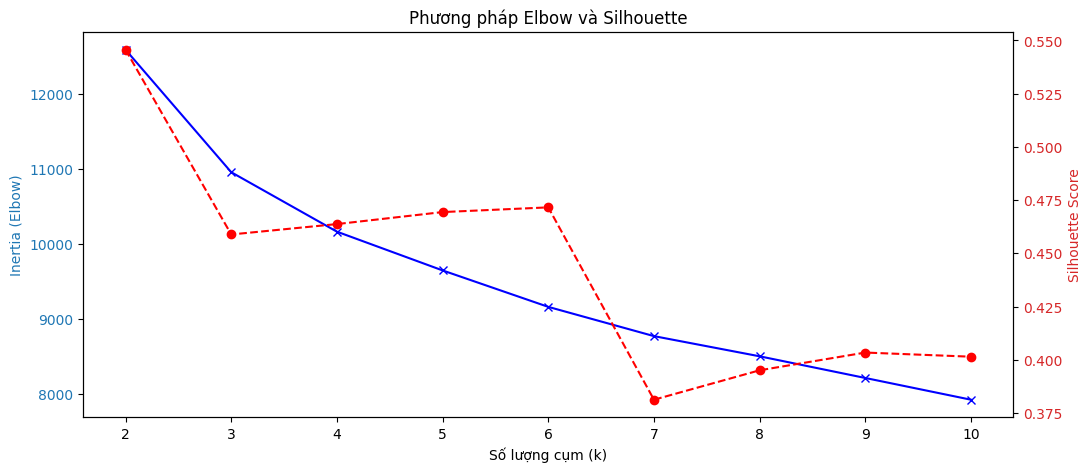

In [4]:
# Cell 4: Vẽ biểu đồ Elbow để chọn số cụm K
# Chạy bước này sẽ mất khoảng 10-30 giây
clusterer.find_optimal_k(max_k=10)

# Hướng dẫn đọc biểu đồ:
# - Đường xanh (Elbow): Tìm điểm gập khuỷu tay (thường là k=3 hoặc 4).
# - Đường đỏ (Silhouette): Càng cao càng tốt.

🚀 Đang phân cụm với k=3...


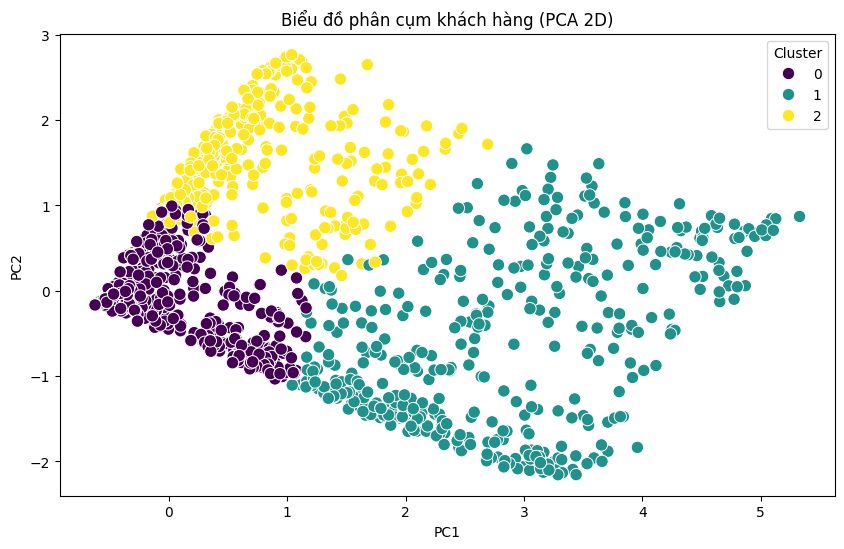

In [5]:
# Cell 5: Chạy K-Means và Vẽ biểu đồ 2D
# Dựa vào biểu đồ trên, giả sử ta chọn K=3 (Bạn có thể sửa số 3 thành số khác)
k_selected = 3 

df_result = clusterer.run_clustering(n_clusters=k_selected)

# Vẽ biểu đồ phân tán (Scatter Plot)
clusterer.visualize_clusters()

In [6]:
# Cell 6: Phân tích đặc điểm của từng cụm
print("📊 THỐNG KÊ CÁC CỤM:")
print(df_result['Cluster'].value_counts())

print("\n🔍 ĐẶC ĐIỂM CỦA TỪNG CỤM (Trung bình các luật):")
# Xem trung bình đặc trưng của từng cụm để biết cụm đó hay mua luật nào
cluster_profile = df_result.groupby('Cluster').mean()

# Hiển thị Top 3 luật đặc trưng nhất cho từng cụm
for cluster_id in range(k_selected):
    print(f"\n--- Cụm {cluster_id} ---")
    # Lấy các cột có giá trị trung bình cao nhất (tức là luật phổ biến nhất trong cụm này)
    top_features = cluster_profile.loc[cluster_id].sort_values(ascending=False).head(3)
    
    for rule_name, score in top_features.items():
        # Lấy lại thông tin chi tiết của luật từ bảng rules gốc
        rule_idx = int(rule_name.split('_')[1]) # Tách số từ "Rule_0"
        rule_info = clusterer.rules.iloc[rule_idx]
        print(f"  - {rule_name} (Tỉ lệ: {score:.2f}): {rule_info['antecedents_parsed']} -> {rule_info['consequents']}")

📊 THỐNG KÊ CÁC CỤM:
Cluster
0    3454
2     478
1     451
Name: count, dtype: int64

🔍 ĐẶC ĐIỂM CỦA TỪNG CỤM (Trung bình các luật):

--- Cụm 0 ---
  - Rule_5 (Tỉ lệ: 0.10): {'HEART OF WICKER LARGE'} -> frozenset({'HEART OF WICKER SMALL'})
  - Rule_22 (Tỉ lệ: 0.10): {'HOME BUILDING BLOCK WORD'} -> frozenset({'LOVE BUILDING BLOCK WORD'})
  - Rule_23 (Tỉ lệ: 0.09): {'LOVE BUILDING BLOCK WORD'} -> frozenset({'HOME BUILDING BLOCK WORD'})

--- Cụm 1 ---
  - Rule_26 (Tỉ lệ: 0.88): {'LUNCH BAG RED SPOTTY'} -> frozenset({'LUNCH BAG WOODLAND'})
  - Rule_30 (Tỉ lệ: 0.88): {'LUNCH BAG RED SPOTTY'} -> frozenset({'LUNCH BAG  BLACK SKULL.'})
  - Rule_37 (Tỉ lệ: 0.88): {'LUNCH BAG RED SPOTTY'} -> frozenset({'LUNCH BAG CARS BLUE'})

--- Cụm 2 ---
  - Rule_12 (Tỉ lệ: 0.92): {'60 TEATIME FAIRY CAKE CASES'} -> frozenset({'PACK OF 60 DINOSAUR CAKE CASES'})
  - Rule_20 (Tỉ lệ: 0.92): {'60 TEATIME FAIRY CAKE CASES'} -> frozenset({'PACK OF 60 PINK PAISLEY CAKE CASES'})
  - Rule_45 (Tỉ lệ: 0.92): {'60 TEATIME 